In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
# 필요 모듈 불러오기
import pandas as pd
import numpy as np
import re

from sklearn.datasets import fetch_20newsgroups
train = fetch_20newsgroups(subset='train')
test = fetch_20newsgroups(subset='test')

In [3]:
# fetch_20newsgroups 객체는 dictionary 형태로 5개의 key를 가지고 있음
train.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

In [4]:
# 학습셋 데이터프레임화해서 살펴보기
df = pd.DataFrame({'data': train['data'], 'target': train['target']})
print(df.shape)
df.head()

(11314, 2)


,data,target
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB

# Document -> Vector
vectorizer = TfidfVectorizer(lowercase=False)
train_vectors = vectorizer.fit_transform(train['data'])
test_vectors = vectorizer.transform(test['data'])

# Naive Bayes Modeling
nb = MultinomialNB(alpha=0.01) # for binary classification <-> GaussianNB(for continous data)
nb.fit(train_vectors, train['target'])

# Evaluation
pred = nb.predict(test_vectors)
f1_score(test['target'], pred, average='weighted')

0.8350184193998174

In [6]:
from sklearn.pipeline import make_pipeline
pipeline = make_pipeline(vectorizer, nb) # 텍스트 데이터 벡터화 및 분류 모델링

predict_classes = pipeline.predict_proba([test['data'][0]]).round(3)[0]
predict_classes

array([0.001, 0.01 , 0.003, 0.047, 0.006, 0.002, 0.003, 0.521, 0.022,
       0.008, 0.025, 0.   , 0.331, 0.003, 0.006, 0.   , 0.003, 0.   ,
       0.001, 0.009])

In [7]:
rank = sorted(range(len(predict_classes)), key=lambda x: predict_classes[x], reverse=True)
for idx in rank:
    print('[{:>3}]위\t{:<4}class ({:.1%})'.format(rank.index(idx) + 1, idx, predict_classes[idx]))

[  1]위	7   class (52.1%)
[  2]위	12  class (33.1%)
[  3]위	3   class (4.7%)
[  4]위	10  class (2.5%)
[  5]위	8   class (2.2%)
[  6]위	1   class (1.0%)
[  7]위	19  class (0.9%)
[  8]위	9   class (0.8%)
[  9]위	4   class (0.6%)
[ 10]위	14  class (0.6%)
[ 11]위	2   class (0.3%)
[ 12]위	6   class (0.3%)
[ 13]위	13  class (0.3%)
[ 14]위	16  class (0.3%)
[ 15]위	5   class (0.2%)
[ 16]위	0   class (0.1%)
[ 17]위	18  class (0.1%)
[ 18]위	11  class (0.0%)
[ 19]위	15  class (0.0%)
[ 20]위	17  class (0.0%)


In [9]:
# !pip install lime
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=train['target_names']) # 파라미터로 1) 특성 선택 방식, 2) BOW 수행 방식, 3) 커널 크기 등 지정 가능

In [10]:
# LIME 객체는 해석하고 싶은 데이터와 흉내내고 싶은 모델을 객체로 받음
exp = explainer.explain_instance(test['data'][0],
                                pipeline.predict_proba,
                                top_labels=1) # 가장 확률이 높은 클래스만 보여줌

In [11]:
exp.show_in_notebook(text=test['data'][0])

In [12]:
# 위에서 top_labels=1 이라고 했기 때문에 해당 라벨이 무엇인지 확인
exp.available_labels()

[7]

In [13]:
exp.as_list(label=7)

[('89', 0.15694608237102295),
 ('SE', 0.10247758193695612),
 ('Gandler', -0.09220841537116621),
 ('NEIL', -0.08823318272224902),
 ('mid', 0.0872458118964868),
 ('v064mb9k', -0.08670288010565237),
 ('demand', 0.08661730211042921),
 ('models', 0.06564827534216514),
 ('88', 0.0626276492870825),
 ('spring', 0.05751749702143688)]

In [14]:
import matplotlib.pyplot as plt
from skimage.color import gray2rgb, rgb2gray
from sklearn.datasets import fetch_olivetti_faces

# 40명 얼굴 사진 데이터 -> 라벨은 고유한 사람 번호
faces = fetch_olivetti_faces()

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data


In [15]:
# 마찬가지로 dictionary 형태
faces.keys()

dict_keys(['data', 'images', 'target', 'DESCR'])

In [16]:
# 400개의 64 x 64 이미지
np.array(faces['images']).shape

(400, 64, 64)

In [17]:
# LIME은 기본적으로 RGB 채널을 가지는 이미지에 대해 사용 가능
X_vec = np.stack([gray2rgb(iimg) for iimg in faces['images']], 0) # 컬러 변환 이후 아래로 쌓기(0: axis=0)
y_vec = faces['target']

print('X_vec 형태는: ', X_vec.shape, '\n' + 'y_vec 형태는: ', y_vec.shape)

X_vec 형태는:  (400, 64, 64, 3) 
y_vec 형태는:  (400,)


In [30]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical # from keras.utils import to_categorical 하면 에러 발생

X_train, X_test, y_train, y_test = train_test_split(X_vec, y_vec, test_size=0.2)

y_train = to_categorical(y_train) # one-hot encoding
y_test = to_categorical(y_test)
y_train_num = np.argmax(y_train, axis=1) # one-hot encoding 결과 1인 인덱스 위치 리턴
y_test_num = np.argmax(y_test, axis=1)

In [19]:
from keras.models import Sequential
from keras.layers import MaxPooling2D
from keras.layers import Conv2D
from keras.layers import Activation, Dropout, Flatten, Dense

In [32]:
num_classes = 40

# Model Build
model = Sequential()
# 필터 수, (커널 행, 열)
model.add(Conv2D(32, (3, 3), input_shape=[64, 64, 3], padding='same')) # 64 x 64 x 3
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) # 출력 이미지 크기를 입력 이미지의 반으로
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))

model.add(Conv2D(64, (3, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Fully-connected layer
model.add(Flatten()) # 벡터 형태로 reshape
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes)) # 40개 Class
model.add(Activation('softmax'))

# Model compile
model.compile(loss='categorical_crossentropy',
             optimizer='rmsprop',
             metrics=['accuracy'])

In [33]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
activation_4 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_5 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 64)       

In [34]:
# Training
from keras.callbacks import EarlyStopping, ModelCheckpoint

mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)
es = EarlyStopping(monitor='val_accuracy', verbose=1, patience=50)
model.fit(X_train, y_train, epochs=500, validation_split=0.2, callbacks=[es, mc])

# Evaluation
score = model.evaluate(X_test, y_test)
print('정확도: ', score[1])
print('Loss: ', score[0])

Epoch 1/500
8/8 [==============================] - 2s 75ms/step - loss: 5.9619 - accuracy: 0.0358 - val_loss: 3.6963 - val_accuracy: 0.0312
Epoch 2/500
8/8 [==============================] - 0s 15ms/step - loss: 3.6884 - accuracy: 0.0356 - val_loss: 3.6875 - val_accuracy: 0.0625
Epoch 3/500
8/8 [==============================] - 0s 15ms/step - loss: 3.6608 - accuracy: 0.0359 - val_loss: 3.7175 - val_accuracy: 0.0000e+00
Epoch 4/500
8/8 [==============================] - 0s 15ms/step - loss: 3.6624 - accuracy: 0.0325 - val_loss: 3.6601 - val_accuracy: 0.0625
Epoch 5/500
8/8 [==============================] - 0s 16ms/step - loss: 3.5741 - accuracy: 0.0705 - val_loss: 3.6577 - val_accuracy: 0.0781
Epoch 6/500
8/8 [==============================] - 0s 15ms/step - loss: 3.5466 - accuracy: 0.0648 - val_loss: 3.4851 - val_accuracy: 0.1094
Epoch 7/500
8/8 [==============================] - 0s 14ms/step - loss: 3.3154 - accuracy: 0.1731 - val_loss: 3.0573 - val_accuracy: 0.2656
Epoch 8/500
8/8 

In [35]:
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm

explainer = lime_image.LimeImageExplainer()

In [36]:
# 이미지를 슈퍼픽셀로 분할하는 알고리즘 설정
# quickshift, slic, felzenswalb 등이 존재
segmenter = SegmentationAlgorithm('slic',
                                   n_segments=100, # 이미지 분할 조각 개수
                                   compactnes=1, # 유사한 파트를 합치는 함수
                                   sigma=1) # 스무딩 역할: 0과 1사이의 float

In [37]:
olivetti_test_index = 0
exp = explainer.explain_instance(X_test[olivetti_test_index],
                                classifier_fn=model.predict, # 40개 class 확률 반환
                                top_labels=5, # 확률 기준 1~5위
                                num_samples=1000, # sample space
                                segmentation_fn=segmenter) # 분할 알고리즘

Text(0.5, 1.0, 'Show mask only')

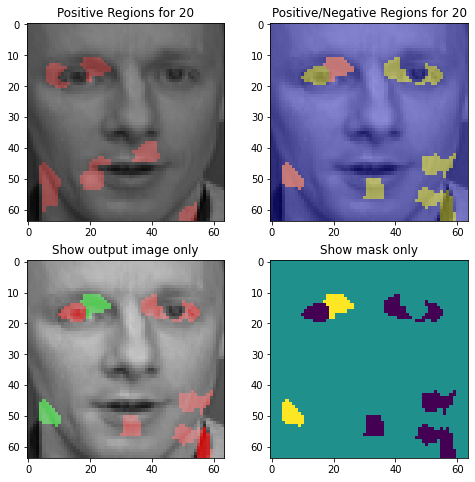

In [38]:
# sklearn의 regressor 기본 설명 모델로 사용

from skimage.color import label2rgb

# 캔버스
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 8))
ax = [ax1, ax2, ax3, ax4]
for i in ax:
    i.grid(False)
# 예측에 가장 도움되는 세그먼트만 출력
temp, mask = exp.get_image_and_mask(y_test_num[0],
                                 positive_only=True, # 설명 모델이 결과값을 가장 잘 설명하는 이미지 영역만 출력
                                 num_features=8, # 분할 영역의 크기
                                 hide_rest=False) # 이미지를 분류하는 데 도움이 되는 서브모듈 외의 모듈도 출력
# label2rgb : 형광색 마스킹
ax1.imshow(label2rgb(mask, temp, bg_label=0), interpolation='nearest')
ax1.set_title('Positive Regions for {}'.format(y_test_num[0]))

# 모든 세그먼트 출력
temp, mask = exp.get_image_and_mask(y_test_num[0],
                                 positive_only=False, # 설명 모델이 결과값을 가장 잘 설명하는 이미지 영역만 출력
                                 num_features=8, # 분할 영역의 크기
                                 hide_rest=False) # 이미지를 분류하는 데 도움이 되는 서브모듈 외의 모듈도 출력

ax2.imshow(label2rgb(4-mask, temp, bg_label=0), interpolation='nearest') # 역변환
ax2.set_title('Positive/Negative Regions for {}'.format(y_test_num[0]))

# 이미지만 출력
ax3.imshow(temp, interpolation='nearest')
ax3.set_title('Show output image only')

# 마스크만 출력
ax4.imshow(mask, interpolation='nearest') # 정수형 array
ax4.set_title('Show mask only')

In [39]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
y_pred_num = np.argmax(y_pred, axis=1)

print(classification_report(y_true=y_test_num, y_pred=y_pred_num))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         1
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         1
           6       1.00      0.75      0.86         4
           7       0.67      0.80      0.73         5
           8       1.00      1.00      1.00         1
           9       0.50      0.33      0.40         3
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         1
          12       1.00      1.00      1.00         1
          13       1.00      1.00      1.00         3
          14       0.67      1.00      0.80         2
          15       1.00      1.00      1.00         1
          16       1.00      1.00      1.00         1
          17       0.33    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [40]:
# score가 낮은 아홉 번째 클래스(사람) 분석
np.where(y_test_num==9)

(array([13, 35, 55]),)

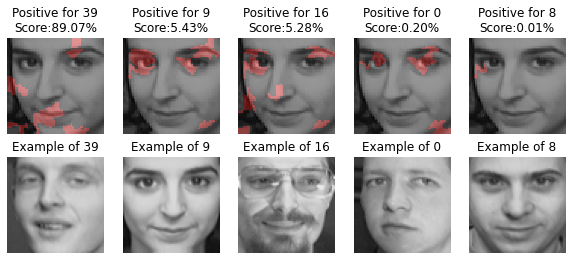

In [41]:
%matplotlib inline
# 테스트셋의 13 번째 데이터 이용
test_idx = 13
exp = explainer.explain_instance(X_test[test_idx],
                              classifier_fn=model.predict,
                              top_labels=5,
                               num_samples=1000,
                              segmentation_fn=segmenter)

fig, m_axs = plt.subplots(2,5, figsize=(10, 4))

for i, (c_ax, gt_ax) in zip(exp.top_labels, m_axs.T):
    temp, mask=exp.get_image_and_mask(i,
                                         positive_only=True, # 설명 모델이 결과값을 가장 잘 설명하는 이미지 영역만 출력
                                         num_features=12, # 분할 영역의 크기
                                         hide_rest=False, # 이미지를 분류하는 데 도움이 되지 않는 세그먼트는 출력 x
                                         min_weight=0.001) 
    c_ax.imshow(label2rgb(mask, temp, bg_label=0),
               interpolation='nearest')
    c_ax.set_title('Positive for {}\nScore:{:2.2f}%'.format(i,
                                                           100 * y_pred[test_idx, i]))
    c_ax.axis('off')
    
    face_id = np.random.choice(np.where(y_train_num==i)[0])
    
    gt_ax.imshow(X_train[face_id])
    gt_ax.set_title('Example of {}'.format(i))
    gt_ax.axis('off')